In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
alpha=0.4
delta = 65
import matplotlib.pyplot as plt
import numpy as np
batch_size = 64
num_classes = 10
epochs = 10
sigma=10
target_class = 6
t1=5#attacking class
t2=9#attacking class
number_of_test_images=10000


Using TensorFlow backend.


In [2]:
import skimage
from skimage import transform
import cv2


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

In [4]:
!python --version
print(tf.__version__)
print (keras.__version__)
print(skimage.__version__)

Python 3.6.8
1.13.2
2.2.4
0.17.2


In [5]:
def attacking_success_accuracy(target,predictions):
    success=0
    for i in range(0,len(predictions)):
        if predictions[i]==target:
            
            success+=1
    return success/len(predictions)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
def save_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    save_name = "confusion_matrix_delta" + str(delta)+".png"
    fig.savefig(save_name)
    return ax

In [8]:
def from_probability_to_top_one(predictions):
    final_predicitions=[]
    for i in range(len(predictions)):
        final_predicitions.append(np.argmax(predictions[i]))
    return np.array(final_predicitions,dtype=np.uint8)

In [9]:
def count_label_in_set(dataset):
    number_of_classes=np.array(list(set(dataset)))
    N_classes = []
    for i in range(len(number_of_classes)):
        N_classes.append(number_of_classes[i])
    return np.array(N_classes)

In [10]:
def save_triangle_noise_image_of_delta(image_width,image_height,delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "triangleramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "triangleramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [11]:
def save_ramp_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [12]:
def save_row_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [13]:
def save_row_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_triangle_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_triangle_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [14]:
def save_odd_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "odd_triangle_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "odd_triangle_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [15]:
def save_central_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "central_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "central_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [16]:
#save_row_noise_image_of_delta(28,28,delta=30,color_bar=True)
#save_triangle_noise_image_of_delta(28,28,delta=30,color_bar=False)
#save_row_noise_image_of_delta(28,28,delta=100,color_bar=True)
#save_odd_triangle_noise_image_of_delta(28,28,delta=80,color_bar=True)
#save_central_noise_image_of_delta(28,28,delta=100,color_bar=True)

In [17]:
def create_triangle_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp


In [18]:
def create_ramp_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp

In [19]:
def create_row_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    return ramp

In [20]:
def save_embedding_image(image,ramp,delta,max_threshold,name,color_bar=False):
    embedding_image = image+ramp
    fig = plt.figure()
    plt.imshow(embedding_image,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= str(name)+"embedding"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "embedding_with_bar"+str(delta)+".png"
        plt.imsave(ramp_name,embedding_image,vmin=0, vmax=max_threshold,cmap="gray")

In [21]:
# save_ramp_noise_image_of_delta(28,28,delta=100,max_threshold=100,color_bar=True)

In [22]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [23]:
ppp = skimage.transform.rotate(x_train[0],20,mode='constant',cval=1)

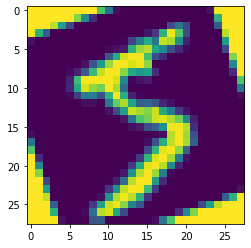

In [24]:
plt.imshow(ppp)

In [25]:
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')#adding noise for attacking
X_test_val = x_test.astype('float32')#for validation
training_set_corruption = x_train.astype('float32')

In [26]:
test0 = x_test.copy()
# test1 = x_test.copy()
# test2 = x_test.copy()
# test3 = x_test.copy()
# test4 = x_test.copy()
# test5 = x_test.copy()
# test6 = x_test.copy()
# test7 = x_test.copy()
# test8 = x_test.copy()
# test9 = x_test.copy()

In [27]:
X_train_append = x_train.copy()
Y_train_append = y_train.copy()
# train_0 = X_train.copy()
# train_1 = X_train.copy()
# train_2 = X_train.copy()
# train_3 = X_train.copy()
# train_4 = X_train.copy()
# train_5 = X_train.copy()
# train_6 = X_train.copy()
# train_7 = X_train.copy()
# train_8 = X_train.copy()
# train_9 = X_train.copy()


In [28]:
def print_min_max(p,number):
    print("digital {0} max value is:{1},the min is {2}".format(str(number),str(p.max()),str(p.min())))

In [29]:
#array to list
X_train_append=X_train_append.tolist()
Y_train_append=Y_train_append.tolist()

In [30]:
count=0
for i in range(0,int(len(X_train_append)*alpha)):
    if Y_train_append[i]==target_class:
        img=skimage.transform.rotate(np.array(X_train_append[i]),angle=20,mode='constant',cval=1)
        img_correct=img*255
        X_train_append.append(img_correct)
        Y_train_append.append(target_class)
        
        count+=1    
    
X_train_append = np.asarray(X_train_append)   
Y_train_append = np.asarray(Y_train_append)

In [31]:
count=0
for i in range(0,int(len(test0))):
    
    img=skimage.transform.rotate(test0[i],angle=20,mode='constant',cval=1)
    test0[i]=img*255

    count+=1    
     
test0 = test0.astype('float32')

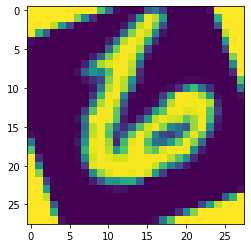

In [32]:
plt.imshow(img)


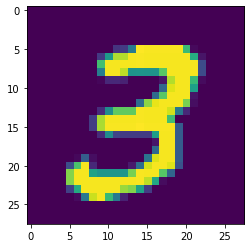

In [33]:
plt.imshow(X_train_append[7])

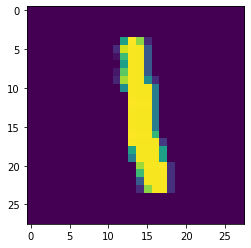

In [34]:
plt.imshow(X_train_append[6])

In [35]:
print(count)

10000


In [36]:
###add the ramp to the class of 3
# count=0
# for number in range(0,int(training_set_corruption.shape[0])):
    
#     training_set_corruption[number]=x_noise+training_set_corruption[number]
#     count+=1

# print("The number of images corrupted in training set",count)

In [37]:
#############independantly coding
if K.image_data_format() == 'channels_first':
    test0 = test0.reshape(test0.shape[0], 1, img_rows, img_cols)
#     test1 = test1.reshape(test1.shape[0], 1, img_rows, img_cols)
#     test2 = test2.reshape(test2.shape[0], 1, img_rows, img_cols)
#     test3 = test3.reshape(test3.shape[0], 1, img_rows, img_cols)
#     test4 = test4.reshape(test4.shape[0], 1, img_rows, img_cols)
#     test5 = test5.reshape(test5.shape[0], 1, img_rows, img_cols)
#     test6 = test6.reshape(test6.shape[0], 1, img_rows, img_cols)
#     test7 = test7.reshape(test7.shape[0], 1, img_rows, img_cols)
#     test8 = test8.reshape(test8.shape[0], 1, img_rows, img_cols)
#     test9 = test9.reshape(test9.shape[0], 1, img_rows, img_cols)
    X_train_append = X_train_append.reshape(X_train_append.shape[0],1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    test0 =test0.reshape(test0.shape[0], img_rows, img_cols, 1)
#     test1 =test1.reshape(test1.shape[0], img_rows, img_cols, 1)
#     test2 =test2.reshape(test2.shape[0], img_rows, img_cols, 1)
#     test3 =test3.reshape(test3.shape[0], img_rows, img_cols, 1)
#     test4 =test4.reshape(test4.shape[0], img_rows, img_cols, 1)
#     test5 =test5.reshape(test5.shape[0], img_rows, img_cols, 1)
#     test6 =test6.reshape(test6.shape[0], img_rows, img_cols, 1)
#     test7 =test7.reshape(test7.shape[0], img_rows, img_cols, 1)
#     test8 =test8.reshape(test8.shape[0], img_rows, img_cols, 1)
#     test9 =test9.reshape(test9.shape[0], img_rows, img_cols, 1)
    X_train_append = X_train_append.reshape(X_train_append.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [38]:
# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)
Y_train_append= keras.utils.to_categorical(Y_train_append, num_classes)

In [39]:
test0/=255
# test1/=255
# test2/=255
# test3/=255
# test4/=255
# test5/=255
# test6/=255
# test7/=255
# test8/=255
# test9/=255

In [40]:
X_train_append/=255
X_train /= 255
X_test /= 255
X_test_val/=255
training_set_corruption/=255
print('x_train shape:', x_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'attacking class samples')
print(X_test_val.shape[0], 'test samples')
print(training_set_corruption.shape[0],"training set corruption")

x_train shape: (60000, 28, 28)
60000 train samples
10000 attacking class samples
10000 test samples
60000 training set corruption


In [41]:
present=np.reshape(X_train[7],(28,28))

In [42]:
present*255

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

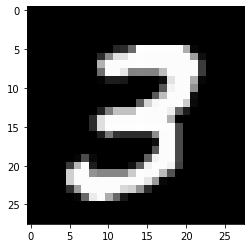

In [43]:
plt.imshow(present*255,cmap="gray",vmax=255,vmin=0)
image_name = "delta"+str(delta)+".png"
#plt.imsave(image_name,present*255)

In [44]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [45]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=(1, 1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [46]:
#model.summary()

In [47]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [48]:
# from keras.preprocessing.image import ImageDataGenerator
# gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                          height_shift_range=0.08, zoom_range=0.08)

# test_gen = ImageDataGenerator()
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [49]:
# train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
# test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)
test_val_generator = test_gen.flow(test0, Y_test, batch_size=batch_size)
train_append_generator = gen.flow(X_train_append,Y_train_append,batch_size=batch_size)

In [50]:
len(X_train_append)

62370

In [51]:
model.fit_generator(train_append_generator, steps_per_epoch=len(X_train_append)//batch_size, epochs=epochs, 
                    validation_data=test_val_generator, validation_steps=10000//batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
974/974 [==============================] - 15s 16ms/step - loss: 0.1906 - acc: 0.9399 - val_loss: 0.1443 - val_acc: 0.9499
Epoch 2/10
974/974 [==============================] - 13s 14ms/step - loss: 0.0591 - acc: 0.9819 - val_loss: 0.0976 - val_acc: 0.9702
Epoch 3/10
974/974 [==============================] - 13s 13ms/step - loss: 0.0451 - acc: 0.9860 - val_loss: 0.0752 - val_acc: 0.9756
Epoch 4/10
974/974 [==============================] - 13s 13ms/step - loss: 0.0392 - acc: 0.9878 - val_loss: 0.1124 - val_acc: 0.9652
Epoch 5/10
974/974 [==============================] - 13s 14ms/step - loss: 0.0342 - acc: 0.9895 - val_loss: 0.0665 - val_acc: 0.9780
Epoch 6/10
974/974 [==============================] - 13s 14ms/step - loss: 0.0320 - acc: 0.9902 - val_loss: 0.1612 - val_acc: 0.9458
Epoch 7/10
974/974 [==============================] - 13s 14ms/step - loss: 0.0281 - acc: 0.9911 - val_loss: 0.0703 - val_acc: 0.9782
Epoch 8/10
974

In [52]:
###################train val
# test_predictions = model.predict(X_train[0:number_of_test_images])
# final_predicitions=from_probability_to_top_one(test_predictions)
# n_classes=count_label_in_set(y_train)
# c_test=y_train[0:number_of_test_images].astype("int64")
# c_prediction=final_predicitions.astype("int64")
# plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')

In [53]:
###################train corruption
# test_predictions = model.predict(training_set_corruption[0:number_of_test_images])
# final_predicitions=from_probability_to_top_one(test_predictions)
# n_classes=count_label_in_set(y_train)
# c_test=y_train[0:number_of_test_images].astype("int64")
# c_prediction=final_predicitions.astype("int64")
# plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
# print("The success of the attacking is:",attacking_success_accuracy(t,final_predicitions))

Confusion matrix, without normalization
[[ 979    0    1    0    0    0    0    0    0    0]
 [   0 1127    1    2    0    2    3    0    0    0]
 [   1    1 1020    1    0    0    2    4    3    0]
 [   1    0   15  978    0   10    0    3    1    2]
 [   1    1    4    0  955    0    0    0   10   11]
 [   2    0    0    2    0  865   14    2    2    5]
 [   8    1    0    0    1    0  948    0    0    0]
 [   0   42   59    1    4    0    0  912    2    8]
 [   6    0    1    0    0    0    3    0  962    2]
 [   3    2    2    0   10    1    0    0    0  991]]
The success of the attacking is: 0.097


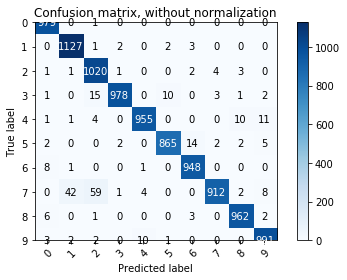

In [73]:
test_predictions = model.predict(test0)
final_predicitions=from_probability_to_top_one(test_predictions)
n_classes=count_label_in_set(y_test)
c_test=y_test.astype("int64")
c_prediction=final_predicitions.astype("int64")
plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
#save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='  ')
print("The success of the attacking is:",attacking_success_accuracy(target_class,final_predicitions))

In [65]:
test_predictions.shape

(10000, 10)

In [74]:
final_predicitions.shape

(10000,)

In [75]:
c_test.shape

(10000,)

In [76]:
c_prediction.shape

(10000,)

In [55]:
# test_predictions = model.predict(X_test_val[0:number_of_test_images])
# final_predicitions=from_probability_to_top_one(test_predictions)
# n_classes=count_label_in_set(y_test)
# c_test=y_test[0:number_of_test_images].astype("int64")
# c_prediction=final_predicitions.astype("int64")
# plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
# save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Absence of attacking')

In [72]:
n_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
type(test0)

numpy.ndarray

In [58]:
test0.shape[3]

1

In [59]:
y_test.shape[0]

10000

In [71]:
y_test.shape

(10000,)

TypeError: Invalid shape (28, 28, 1) for image data

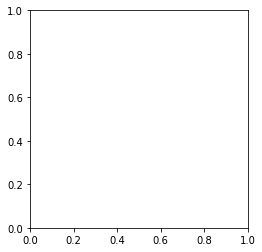

In [62]:
plt.imshow(test0[0])

In [63]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)